tensor(18.1071, grad_fn=<SqrtBackward0>)
tensor(17.6367, grad_fn=<SqrtBackward0>)
tensor(16.5303, grad_fn=<SqrtBackward0>)
tensor(10.7286, grad_fn=<SqrtBackward0>)
tensor(4.5981, grad_fn=<SqrtBackward0>)
tensor(3.5573, grad_fn=<SqrtBackward0>)
tensor(2.9664, grad_fn=<SqrtBackward0>)
tensor(2.5264, grad_fn=<SqrtBackward0>)
tensor(2.1864, grad_fn=<SqrtBackward0>)
tensor(1.9276, grad_fn=<SqrtBackward0>)
tensor(1.7324, grad_fn=<SqrtBackward0>)
tensor(1.5829, grad_fn=<SqrtBackward0>)
tensor(1.4689, grad_fn=<SqrtBackward0>)
tensor(1.3786, grad_fn=<SqrtBackward0>)
tensor(1.3057, grad_fn=<SqrtBackward0>)
tensor(1.2482, grad_fn=<SqrtBackward0>)
tensor(1.2011, grad_fn=<SqrtBackward0>)
tensor(1.1645, grad_fn=<SqrtBackward0>)
tensor(1.1353, grad_fn=<SqrtBackward0>)
tensor(1.1111, grad_fn=<SqrtBackward0>)
tensor(1.0909, grad_fn=<SqrtBackward0>)
tensor(1.0729, grad_fn=<SqrtBackward0>)
tensor(1.0580, grad_fn=<SqrtBackward0>)
tensor(1.0451, grad_fn=<SqrtBackward0>)
tensor(1.0336, grad_fn=<SqrtBackward

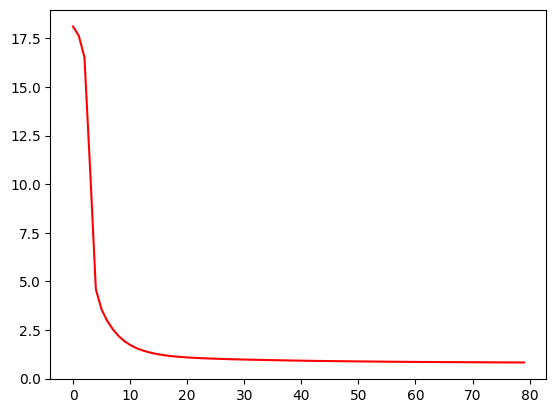

In [5]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn
torch.manual_seed(0)

loss_list=[] #存损失函数数值，画图使用

#加载数据
train_data=pd.read_csv("covid.train.csv")
test_data=pd.read_csv("covid.test.csv")

train_inputs=train_data.iloc[:,1:94]#去掉第一列的序号和最后一列的ground truth
train_outputs=train_data.iloc[:,94]
test_inputs=test_data.iloc[:,1:94]

#train_inputs:(2700,93),outputs(2700，1)
train_inputs=torch.tensor(train_inputs.values,dtype=torch.float32)
train_outputs=torch.tensor(train_outputs.values,dtype=torch.float32)
#test_inputs:(893,93)
test_inputs=torch.tensor(test_inputs.values,dtype=torch.float32)

#输入标准化:
mean=torch.mean(train_inputs[:,0:94],dim=0)
std=torch.std(train_inputs[:,0:94],dim=0,unbiased=False)
train_inputs=(train_inputs-mean)/std
test_inputs=(test_inputs-mean)/std

#参数设定
def set_parameters(layer,dim):
    w=[]
    b=[]
    i=0
    for i in range(layer):
        w.append(nn.Parameter(torch.randn(dim[i],dim[i+1],requires_grad=True)*0.01))
        b.append(nn.Parameter(torch.zeros(1,dim[i+1],requires_grad=True)))
        i=i+1
    return [w,b]    
[w,b]=set_parameters(2,[93,100,1])#93个输入，两层网络，第一层节点个数为100，第二层节点个数为1

#前向传播+计算梯度
def forward(layer,w,b,x,y,flag=0):
    a=[]
    a.append(x.T)
    a[0].requires_grad_(True)
    n=x.shape[0]
    i=0
    for i in range(layer):
        a.append(torch.relu(torch.mm(w[i].T,a[i])+b[i].T))
        w[i].retain_grad()
        b[i].retain_grad()
        a[i+1].retain_grad()
        i=i+1
    loss=torch.sqrt(((a[i]-y)*(a[i]-y)).sum()/n)
    if(flag==1):#每100步存一次loss,打印一次loss
        print(loss)
        loss_list.append(loss.item())
    loss.backward()
    w_grad=[]
    b_grad=[]
    i=0
    for i in range(layer):
        w_grad.append(w[i].grad)
        b_grad.append(b[i].grad)
        i=i+1
    
    return [w_grad,b_grad]

#动量下降，优化参数
def optimize(layer,w,b,inputs,outputs):
    Vw_grad=[]
    Vb_grad=[]
    i=0
    for i in range(layer):
        Vw_grad.append(torch.zeros_like(w[i]))
        Vb_grad.append(torch.zeros_like(b[i]))
    i=0
    for i in range(8000):
        if(i%100==0): #每100步存一次Loss
            [w_grad,b_grad]=forward(layer,w,b,inputs,outputs,1)
        else:
            [w_grad,b_grad]=forward(layer,w,b,inputs,outputs,0)
        j=0
        for j in range(layer):
            Vw_grad[j]=Vw_grad[j]*0.9+0.1*w_grad[j]
            Vb_grad[j]=Vb_grad[j]*0.9+0.1*b_grad[j]
            w[j]=w[j]-0.005*Vw_grad[j]
            b[j]=b[j]-0.005*Vb_grad[j]
            #梯度清零
            w_grad[j].zero_()
            b_grad[j].zero_()
            j=j+1
        i=i+1
        
optimize(2,w,b,train_inputs,train_outputs)         

#预测test
def predict(w,b,layer,x):
    i=1
    a=[]
    a.append(torch.relu(torch.mm(w[0].T,x.T)+b[0].T))
    for i in range(layer):
        a.append(torch.relu(torch.mm(w[1].T,a[i-1])+b[1].T))
        i=i+1
    print("test_outputs",a[i])
    
predict(w,b,2,test_inputs)

#画损失数值随步数下降的图
plt.figure()
x=range(0,80)
plt.plot(x,loss_list, 'r-')